1. Final Zone Allocation per UAV:
UAV 1: Zones [32, 7, 26] (Priorities: [8, 5, 2])
UAV 2: Zones [10, 14, 18] (Priorities: [8, 4, 5])
UAV 3: Zones [47, 44, 24] (Priorities: [8, 5, 6])
UAV 4: Zones [34, 22, 46] (Priorities: [3, 6, 2])
UAV 5: Zones [11, 2, 33] (Priorities: [4, 9, 3])
UAV 6: Zones [29, 8, 30] (Priorities: [3, 4, 10])
UAV 7: Zones [9, 35, 19] (Priorities: [7, 7, 10])
UAV 8: Zones [48, 27, 49] (Priorities: [2, 1, 9])
UAV 9: Zones [20, 41, 16] (Priorities: [6, 9, 7])
UAV 10: Zones [5, 6, 25] (Priorities: [6, 1, 7])
UAV 11: Zones [37, 40] (Priorities: [9, 4])
UAV 12: Zones [1, 43] (Priorities: [7, 10])
UAV 13: Zones [39, 31] (Priorities: [5, 4])
UAV 14: Zones [50, 28] (Priorities: [10, 2])
UAV 15: Zones [42, 21] (Priorities: [1, 9])
UAV 16: Zones [45, 17] (Priorities: [4, 9])
UAV 17: Zones [38, 23] (Priorities: [10, 6])
UAV 18: Zones [4, 3] (Priorities: [9, 2])
UAV 19: Zones [12, 13] (Priorities: [6, 9])
UAV 20: Zones [36, 15] (Priorities: [4, 7])

2. Optimized Paths (Structur

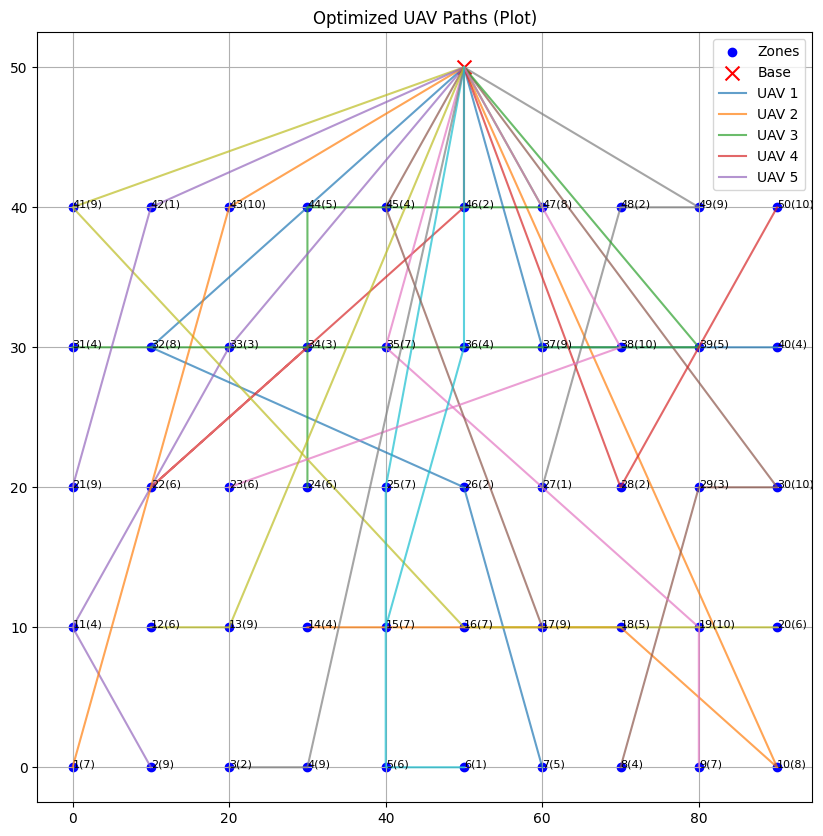

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Constants
NUM_ZONES = 50
NUM_UAVS = 20
GRID_SIZE = 100
BASE_POSITION = np.array([50, 50])
MAX_SPEED = 10  # units/time
ENERGY_PER_DISTANCE = 1  # unit energy per unit distance

# Generate zone positions (10x5 grid)
def generate_zone_positions():
    positions = []
    for i in range(NUM_ZONES):
        x = (i % 10) * 10
        y = (i // 10) * 10
        positions.append(np.array([x, y]))
    return positions

# Generate random priorities (1-10)
def generate_priorities():
    return [random.randint(1, 10) for _ in range(NUM_ZONES)]

# Distance between two points
def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Genetic Algorithm for Zone Allocation
class GeneticAlgorithm:
    def __init__(self, num_zones, num_uavs, positions, priorities):
        self.num_zones = num_zones
        self.num_uavs = num_uavs
        self.positions = positions
        self.priorities = priorities
        self.population_size = 100
        self.generations = 200
        self.crossover_rate = 0.8
        self.mutation_rate = 0.1

    def fitness(self, allocation):
        # Allocation is a list of lists: each sublist is zones for a UAV
        total_distance = 0
        total_priority_penalty = 0
        for uav_zones in allocation:
            if not uav_zones:
                continue
            # Start from base, visit zones in order of priority (descending)
            path = [BASE_POSITION] + [self.positions[z-1] for z in sorted(uav_zones, key=lambda z: -self.priorities[z-1])]
            for i in range(1, len(path)):
                total_distance += distance(path[i-1], path[i])
            # Priority penalty: lower if high priorities are visited early
            sorted_zones = sorted(uav_zones, key=lambda z: -self.priorities[z-1])
            avg_priority = np.mean([self.priorities[z-1] for z in sorted_zones[:len(sorted_zones)//2]])
            total_priority_penalty += 10 - avg_priority
        # Swarm cohesion: minimize max pairwise distance at any time (simplified as variance in positions)
        all_positions = [self.positions[z-1] for uav_zones in allocation for z in uav_zones]
        if all_positions:
            centroid = np.mean(all_positions, axis=0)
            dispersion = np.mean([distance(p, centroid)**2 for p in all_positions])
        else:
            dispersion = 0
        return 0.4 * total_distance + 0.3 * total_priority_penalty + 0.3 * dispersion

    def initialize_population(self):
        population = []
        zones = list(range(1, self.num_zones + 1))
        for _ in range(self.population_size):
            random.shuffle(zones)
            allocation = [[] for _ in range(self.num_uavs)]
            for i, zone in enumerate(zones):
                allocation[i % self.num_uavs].append(zone)
            population.append(allocation)
        return population

    def crossover(self, parent1, parent2):
        child = [[] for _ in range(self.num_uavs)]
        for i in range(self.num_uavs):
            if random.random() < self.crossover_rate:
                child[i] = parent1[i] + parent2[i]
            else:
                child[i] = parent1[i] if random.random() < 0.5 else parent2[i]
        return child

    def mutate(self, allocation):
        for uav_zones in allocation:
            if random.random() < self.mutation_rate and uav_zones:
                idx1, idx2 = random.sample(range(len(uav_zones)), 2)
                uav_zones[idx1], uav_zones[idx2] = uav_zones[idx2], uav_zones[idx1]
        return allocation

    def run(self):
        population = self.initialize_population()
        for _ in range(self.generations):
            fitnesses = [self.fitness(ind) for ind in population]
            sorted_pop = [x for _, x in sorted(zip(fitnesses, population))]
            new_population = sorted_pop[:self.population_size // 2]
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(new_population[:50], 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_population.append(child)
            population = new_population
        best_allocation = min(population, key=self.fitness)
        return best_allocation

# Ant Colony Optimization for Path Planning per UAV
class AntColonyOptimization:
    def __init__(self, zones, positions, priorities, base_position):
        self.zones = zones  # List of zone indices (1-based)
        self.positions = positions
        self.priorities = priorities
        self.base_position = base_position
        self.num_ants = 100
        self.iterations = 500
        self.evaporation = 0.5
        self.alpha = 1  # Pheromone importance
        self.beta = 2   # Heuristic importance
        self.pheromone = defaultdict(float)
        self.best_path = None
        self.best_distance = float('inf')

    def heuristic(self, zone1, zone2):
        dist = distance(self.positions[zone1-1], self.positions[zone2-1])
        priority_bonus = self.priorities[zone2-1] / 10  # Favor high priority
        return 1 / (dist + 1e-6) * (1 + priority_bonus)

    def run(self):
        for _ in range(self.iterations):
            for ant in range(self.num_ants):
                path = [0]  # 0 represents base
                visited = set()
                current = 0
                while len(path) < len(self.zones) + 1:
                    if current == 0:
                        next_zone = random.choice(self.zones)
                    else:
                        visited.add(current)
                        probabilities_list = []
                        valid_next_zones = [z for z in self.zones if z not in visited]

                        if not valid_next_zones:
                            break # All zones for this UAV have been visited

                        for zone in valid_next_zones:
                            tau = self.pheromone[(current, zone)]
                            eta = self.heuristic(current, zone)
                            prob = (tau ** self.alpha) * (eta ** self.beta)
                            probabilities_list.append((zone, prob))

                        total_prob_sum = sum(p for _, p in probabilities_list)

                        if total_prob_sum == 0:
                            # If all calculated probabilities are zero (e.g., at the start due to zero pheromones),
                            # choose a random unvisited zone to ensure exploration.
                            next_zone = random.choice(valid_next_zones)
                        else:
                            # Normalize probabilities and make a choice
                            normalized_probabilities = [(z, p / total_prob_sum) for z, p in probabilities_list]
                            next_zone = random.choices([z for z, _ in normalized_probabilities],
                                                       [p for _, p in normalized_probabilities])[0]
                    path.append(next_zone)
                    current = next_zone
                # Evaluate path
                full_path = [self.base_position] + [self.positions[z-1] for z in path[1:]]
                dist = sum(distance(full_path[i], full_path[i+1]) for i in range(len(full_path)-1))
                if dist < self.best_distance:
                    self.best_distance = dist
                    self.best_path = path[1:]
                # Update pheromones
                for i in range(len(path)-1):
                    self.pheromone[(path[i], path[i+1])] += 1 / dist
            # Evaporate
            for key in list(self.pheromone.keys()):
                self.pheromone[key] *= (1 - self.evaporation)
        return self.best_path, self.best_distance

# Main execution
def main():
    positions = generate_zone_positions()
    priorities = generate_priorities()

    # Run GA for allocation
    ga = GeneticAlgorithm(NUM_ZONES, NUM_UAVS, positions, priorities)
    allocation = ga.run()

    # Run ACO for each UAV's path
    paths = []
    total_distance = 0
    total_priority_penalty = 0
    for uav_zones in allocation:
        if not uav_zones:
            paths.append([])
            continue
        aco = AntColonyOptimization(uav_zones, positions, priorities, BASE_POSITION)
        path, dist = aco.run()
        paths.append(path)
        total_distance += dist
        # Priority penalty
        sorted_zones = sorted(uav_zones, key=lambda z: -priorities[z-1])
        avg_priority = np.mean([priorities[z-1] for z in sorted_zones[:len(sorted_zones)//2]])
        total_priority_penalty += 10 - avg_priority

    # Swarm dispersion
    all_positions = [positions[z-1] for uav_zones in allocation for z in uav_zones]
    if all_positions:
        centroid = np.mean(all_positions, axis=0)
        dispersion = np.mean([distance(p, centroid)**2 for p in all_positions])
    else:
        dispersion = 0

    fitness_score = 0.4 * total_distance + 0.3 * total_priority_penalty + 0.3 * dispersion

    # Output 1: Final zone allocation per UAV
    print("1. Final Zone Allocation per UAV:")
    for i, uav_zones in enumerate(allocation):
        print(f"UAV {i+1}: Zones {uav_zones} (Priorities: {[priorities[z-1] for z in uav_zones]})")

    # Output 2: Optimized Paths (Structured Output):
    print("\n2. Optimized Paths (Structured Output):")
    for i, path in enumerate(paths):
        if not path:
            print(f"UAV {i+1}: No zones")
            continue
        full_path = [BASE_POSITION] + [positions[z-1] for z in path]
        cumulative_dist = 0
        print(f"UAV {i+1}: Base -> ", end="")
        for j, zone in enumerate(path):
            dist_to_next = distance(full_path[j], full_path[j+1])
            cumulative_dist += dist_to_next
            time = dist_to_next / MAX_SPEED
            print(f"Zone {zone} (Time: {time:.1f}, CumDist: {cumulative_dist:.1f}) -> ", end="")
        print("End")

    # Output 3: Swarm performance score
    print(f"\n3. Swarm Performance Score: {fitness_score:.1f} (Total Distance: {total_distance:.1f}, Avg Priority Coverage: {10 - total_priority_penalty / NUM_UAVS:.1f}, Swarm Dispersion: {dispersion:.1f})")

    # Output 4: Short explanation of optimization method
    print("\n4. Short Explanation of Optimization Method:")
    print("A hybrid soft computing approach was used: Genetic Algorithm (GA) for zone allocation (evolving groupings to minimize distance and priority penalties) and Ant Colony Optimization (ACO) for intra-UAV path optimization (ants deposit pheromones on promising routes, favoring priority-first visits). This ensures adaptability, handles multi-objectives, and mimics swarm intelligence for efficient disaster response.")

    # Plot (for visual output of paths)
    # Ensures plot displays in Colab
    %matplotlib inline
    plt.figure(figsize=(10, 10))
    for i, pos in enumerate(positions):
        plt.scatter(pos[0], pos[1], c='blue', label='Zones' if i==0 else "")
        plt.text(pos[0], pos[1], f'{i+1}({priorities[i]})', fontsize=8)
    plt.scatter(BASE_POSITION[0], BASE_POSITION[1], c='red', marker='x', s=100, label='Base')
    for i, path in enumerate(paths):
        if path:
            full_path = [BASE_POSITION] + [positions[z-1] for z in path]
            xs, ys = zip(*full_path)
            plt.plot(xs, ys, label=f'UAV {i+1}' if i<5 else "", alpha=0.7)
    plt.legend()
    plt.title("Optimized UAV Paths (Plot)")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()